In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.io

In [2]:
def Cone(x, phi):
    # Set parameters
    alpha_c = 2.4e-4#-9.602e-6
    beta_c = 1.148e-5
    alpha_h = 0.5292
    gamma = 0.764
    tau_y = 0.056
    tau_z = 0.5769
    tau_h = 0.371
    # Set functions
    Tk = np.arange(0,5,dt)
    K_y = Tk*np.exp(-Tk/tau_y)/tau_y**2
    K_z = gamma*K_y + (1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2
    K_h = Tk*np.exp(-Tk/tau_h)/tau_h**2
    K_y = K_y/np.sum(K_y) #Normalize
    K_z = K_z/np.sum(K_z)
    K_h = K_h/np.sum(K_h)
    plt.plot(K_y, label = 'K_y')
    plt.plot(K_z, label = 'K_z')
    plt.plot(K_h, label = 'K_h')
    plt.legend()
    plt.show()
    y = np.convolve(x, K_y)
    y = y[0:len(x)]
    z = np.convolve(x, K_z)
    z = z[0:len(x)]
    # set r, h
    r = np.zeros(len(x))
    h = np.zeros(len(x))
    for i in range(len(x)-1): 
        if i - len(K_h)+1<0:
            K_ht = K_h[::-1][-i-1:len(K_h)]
            h[i] = alpha_h*sum(K_ht*r[0:len(K_ht)])
        else:
            K_ht = K_h[::-1]
            h[i] = alpha_h*sum(K_ht*r[i-len(K_ht)+1:i+1])
        r[i]=alpha_c*y[i]/(1+beta_c*z[i])-phi*h[i]
    return r,h

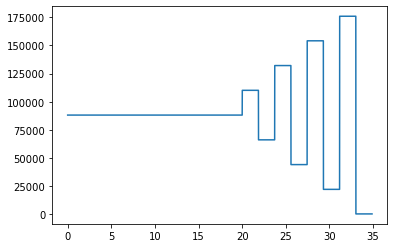

88166.66666666667


In [3]:
# Stimulus in Drinnenberg's paper
lightlevels = scipy.io.loadmat('F:/我的雲端硬碟/Retina exp/Drinnenberg2018 code by author/lightLevels.mat')
light = lightlevels['R_s'][:,1] # light intensity
dt = 0.001
ad = 20
du = 1.86
adaptation = np.ones(int(ad/dt))
stimulus = np.ones(int(du/dt))
x = light[0]*adaptation
for i in range(len(light)-1):
    x = np.append(x, light[i+1]*stimulus)
T = np.arange(dt,ad+du*8+1e-7,dt)
plt.plot(T,x)
plt.show()
print(np.mean(light))

In [4]:
light

array([ 88166.66666667, 110129.16666667,  66204.16666667, 132091.66666667,
        44241.66666667, 154054.16666667,  22279.16666667, 175840.96666667,
          492.36666667])

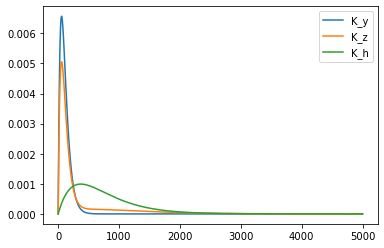

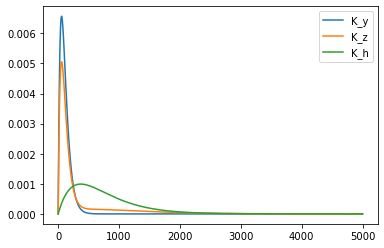

In [5]:
r1, h1 = Cone(x, 1)
r0, h0 = Cone(x, 0)

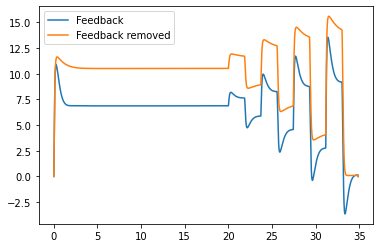

In [6]:
# figure 7
plt.plot(T,r1, label = 'Feedback')
plt.plot(T,r0, label = 'Feedback removed')
plt.legend()
plt.show()

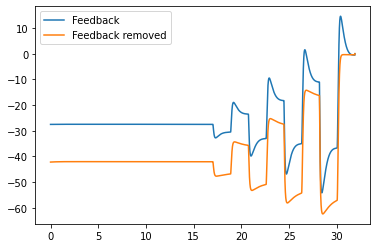

In [7]:
r1 = -4*r1[T>3]
r0 = -4*r0[T>3]
T1 = T[T>3]-3
plt.plot(T1,r1, label = 'Feedback')
plt.plot(T1,r0, label = 'Feedback removed')
plt.legend()
plt.show()

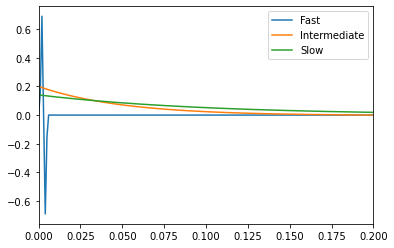

In [8]:
# Bipolar pathway
mu = 3e-3
sigma = 1e-3
tau2 = 5e-2
tau3 = 1e-1
c2 = 50
Tk2 = np.arange(0,10,dt)
K1 = np.sin(np.pi*Tk2/mu)*np.exp(-1/2*((Tk2-mu)/sigma)**2)/np.sqrt(2*np.pi*sigma) #fast pathway
K2 = np.exp(-Tk2/tau2)/tau2 - np.exp(-Tk2/(c2*tau2))/(c2*tau2) # intermediate pathway
K3 = np.exp(-Tk2/tau3)/tau3 # slow pathway

K1 = K1/np.sqrt(np.sum(K1**2))
K2 = K2/np.sqrt(np.sum(K2**2))
K3 = K3/np.sqrt(np.sum(K3**2))
plt.plot(Tk2, K1, label = 'Fast')
plt.plot(Tk2, K2, label = 'Intermediate')
plt.plot(Tk2, K3, label = 'Slow')
plt.legend()
plt.xlim(0,0.2)
plt.show()

In [15]:
def Bipolar(r_in):
    v_dark = 23
    K_1_2_3 = [K1,K2,K3]
    theta_p_k = [[0.1,-0.1], [0,0], [-23.5,-23.5]] # theta_p_k = theta[p][k]
    b_p_k = [[[] for i in range(2)] for j in range(3)] # 2[] in 3[]
    r_baseline = r_in + v_dark
    for k in range(2):
        for p in range(3):
            btemp = (-1)**k*(np.convolve(r_baseline, K_1_2_3[p], 'valid') - theta_p_k[p][k])  #
            btemp[btemp<0] = 0
            b_p_k[p][k] = np.array(btemp)
    return b_p_k

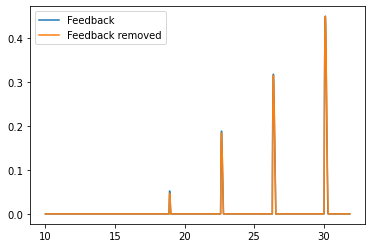

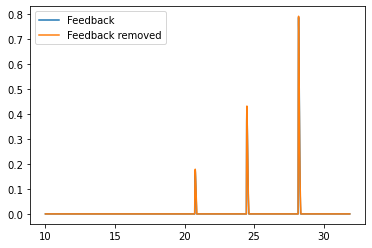

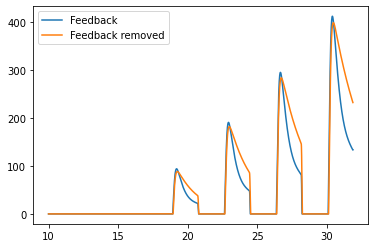

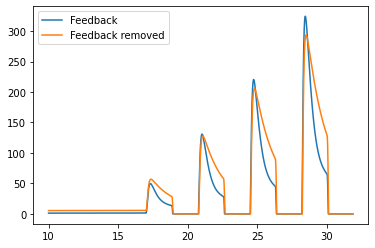

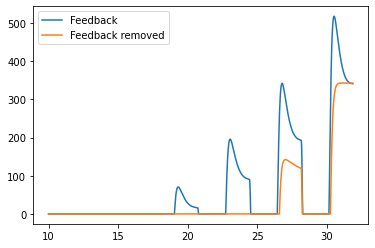

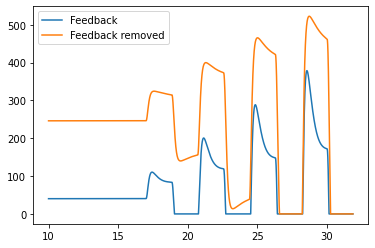

In [16]:
br1 = Bipolar(r1)
br0 = Bipolar(r0)
for i in range(3):
    for j in range(2):
        plt.plot(T1[len(K1)-1:], br1[i][j], label = 'Feedback')
        plt.plot(T1[len(K1)-1:], br0[i][j], label = 'Feedback removed')
        plt.legend()
        plt.show()
# plt.xlim(27,30)
# plt.ylim(0,3000)

In [11]:
def RGC(w_gpk, alpha_g, theta_g, b):
    Ig = 0
    for p in range(np.size(w_gpk, 0)):
        for k in range(np.size(w_gpk, 1)):
            Ig = Ig + w_gpk[p][k]*b[p][k]
    Kg = np.array(K1)
    Ig_velocity = np.convolve(Ig, Kg)
    Ig_velocity = Ig_velocity[0:len(Ig)]
    R = (1-alpha_g)*Ig + alpha_g*Ig_velocity - theta_g
    R[R<0] = 0
    return R

In [12]:
# 7 RGC simulation

#(i)
w1 = [[0 for i in range(2)] for j in range(3)]
w1[1][1] = 1
R1 = RGC(w1, 1, 0.3, br)
R1b = RGC(w1, 1, 0.3, brb)
plt.plot(T1, R1, label = 'Feedback')
plt.plot(T1, R1b, label = 'Feedback removed')
plt.xlim(15, 30)
plt.ylim(0, 10)
plt.legend()
plt.show()

#(ii)
w2 = [[0 for i in range(2)] for j in range(3)]
w2[1][1] = 1
R2 = RGC(w2, 0, 0.1, br)
R2b = RGC(w2,0, 0.1, brb)
plt.plot(T1, R2, label = 'Feedback')
plt.plot(T1, R2b, label = 'Feedback removed')
plt.xlim(15, 32)
plt.ylim()
plt.legend()
plt.show()

#(iii)
w3 = [[0 for i in range(2)] for j in range(3)]
w3[1][1] = 4 # value is slightly different from the paper
w3[2][1] = 1
R3 = RGC(w3, 0, 0, br)
R3b = RGC(w3, 0, 0, brb)
plt.plot(T1, R3, label = 'Feedback')
plt.plot(T1, R3b, label = 'Feedback removed')
plt.xlim(15, 32)
plt.ylim()
plt.legend()
plt.show()

# (iv), (v)
w4 = [[0 for i in range(2)] for j in range(3)]
w4[0][0] = 3
w4[1][1] = -1
R4 = RGC(w4,1,0,br)
R4b = RGC(w4,1,0,brb)
plt.plot(T1, R4, label = 'Feedback')
plt.plot(T1, R4b, label = 'Feedback removed')
plt.xlim(15, 32)
plt.legend()
plt.show()

# (vi)
w5 = [[0 for i in range(2)] for j in range(3)]
w5[1][0] = 1
w5[2][0] = 10
R5 = RGC(w5, 0, -0.1, br)
R5b = RGC(w5, 0, -0.1, brb)
plt.plot(T1, R5, label = 'Feedback')
plt.plot(T1, R5b, label = 'Feedback removed')
plt.xlim(15, 32)
plt.ylim()
plt.legend()
plt.show()

#(vii)
w6 = [[0 for i in range(2)] for j in range(3)]
w6[0][1] = 1
R6 = RGC(w6, 0, 0, br)
R6b = RGC(w6, 0, 0, brb)
plt.plot(T1, R6, label = 'Feedback')
plt.plot(T1, R6b, label = 'Feedback removed')
plt.xlim(15, 30)
plt.ylim()
plt.legend()
plt.show()

NameError: name 'br' is not defined

In [ ]:
# plot the final result again 
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Ganglion cell output', color='tab:orange')
ax1.plot(T1,R1,color = 'tab:orange')
ax1.plot(T1,R1b,color = 'tab:orange',linestyle='dashed')
ax1.tick_params(axis='y',labelsize=16,labelcolor='tab:orange')